# Recurrent Neural Network Example - Classifying Handwritten Digits

This example shows how a recurrent neural network (RNN) can classify handwritten digits. We use the MNIST dataset with $60000$ examples of $28\times28$ images. This task is usually solved by giving the whole image into a neural network with an input layer of dimension $28\cdot28=784$. We however split the image into a sequence where each step corresponds to a row with the length $28$.


You can find a implementation with Tensorflow for this task here: https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/recurrent_network.ipynb


## MNIST Dataset 
The MNIST dataset contains $60000$ examples for training and $10000$ examples for testing. The digits have been size-normalized and centered in a fixed-size image ($28\times28$ pixels) with values from $0$ to $1$.

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)
More information: http://yann.lecun.com/exdb/mnist/

## Many to One
For each image the RNN receives a sequence of lenght $28$ ($28$ rows). Each input has $28$ features ($28$ pixels per row). The task is to classify what digit is shown in the image after the whole sequence has been given to the RNN. Therefore, we choose a *many-to-one* input-output relation.

<img src="https://www.easy-tensorflow.com/images/NN/06.png"/>


In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms  # This package includes the MNIST dataset

We load the training and test datasets and create a DataLoader object, respectively.

In [2]:
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 100
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

0it [00:00, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


0it [00:00, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


0it [00:00, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


0it [00:00, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...
Done!


C:\Users\ga76hug\Anaconda3\envs\ai_automotive_technology_anacon\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


To get a better understanding what the RNN 'sees' we take an example image and visualize the sequence of rows.

Which digit is shown here?

<IPython.core.display.Javascript object>


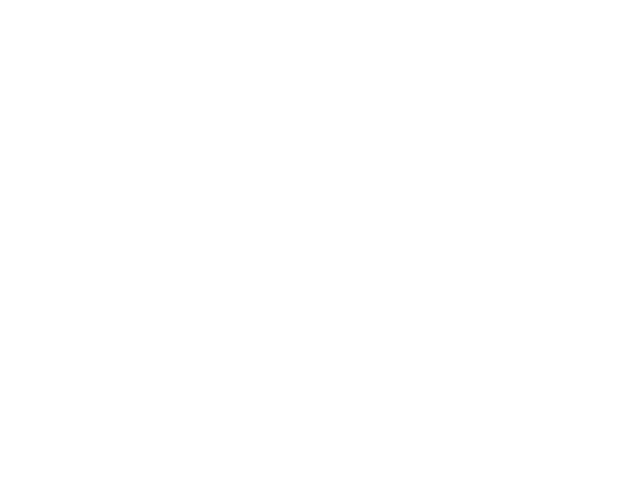

In [3]:
fig1 = plt.figure()
ax1 = fig1.gca()
ax1.tick_params(left=False, labelleft=False)

# Meaning of the indices (the three zeros)
# 1. Take the image, not the label
# 2. Random image in the batch
# 3. First channel (there is only one since the MNIST contains only grayscale images)
example_image = next(iter(train_loader))[0][torch.randint(batch_size - 1, (1,)).item(), 0]

def function_for_animation(frame_index):
    ax1.clear()
    image = ax1.imshow(example_image[frame_index:frame_index+1, :], animated=True, cmap='gray_r')
    ax1.set_title('t = '+str(frame_index))
    plt.draw()
    return image,

ani = matplotlib.animation.FuncAnimation(fig1, function_for_animation, interval=150, frames=28, blit=True)

Here is the solution:

<IPython.core.display.Javascript object>


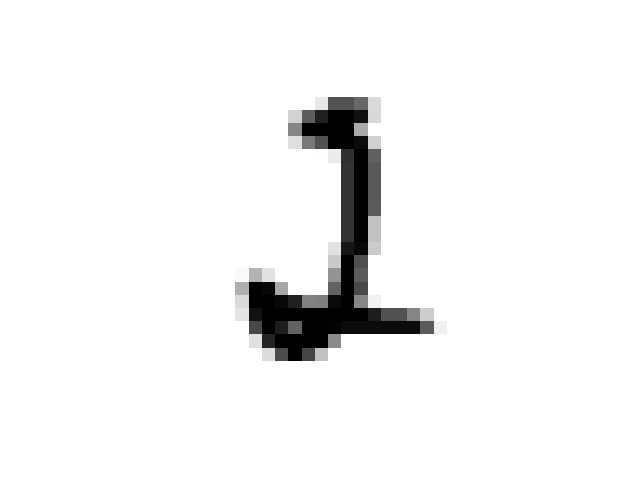

In [4]:
plt.figure()
plt.imshow(example_image, cmap='gray_r')
plt.show()

## RNN with LSTM Architecture
We choose a RNN with LSTM cells.
<img src="http://colah.github.io/images/post-covers/lstm.png"/>

The input and output sizes are fixed but you can try different sizes for the hidden layer. Both, the hidden state $h_t$ and the cell state $c_t$ will have this size!

In [5]:
input_size = 28  # Each image: 28x28 -> Sequence of length 28 and input dimension of 28
output_size = 10  # Digits 0-9
hidden_size = 20

The architecture of the model is set with the $\_\_init\_\_()$ method. To complete the model we also have to implement the forward pass.

In [6]:
class LSTMnist(torch.nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMnist, self).__init__()
        
        # LSTM layer
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        
        # The linear layer that maps from hidden state space to digits
        self.hidden2digits = torch.nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, sequence_input):
        
        # Remove the channel dimension of images
        sequence_squeezed = torch.squeeze(sequence_input, dim=1)
        
        # Give the batch with sequences to the LSTM layer
        lstm_out, (h_last, c_last) = self.lstm(sequence_squeezed)  
        
        # Use the last hidden states of the batch to generate non-normalized predictions 
        # Meaning of the index 0: Use the last hidden state of the first layer. (Our network only has one hidden layer)
        logits = self.hidden2digits(h_last[0])
        
        # Apply a softmax function to generate probabilites for the classes
        # Apply the logarithm to prepare for the negative log likelihood loss
        digits = torch.nn.functional.log_softmax(logits, dim=1)
        return digits
    
# Create an instance of the model
model = LSTMnist(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

To train the model we have to create an optimizer and choose the model parameters we want to train. We use a gradient descent methode and decide to train all model parameters. Try different learning rates and observe the effect on the training later!

In [7]:
learning_rate = 1e-1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

For classification tasks a common loss function is the negative log likelihood. Explaining this loss function is out of the scope of this notebook. But you can find a good introduction here: https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/

In [8]:
loss_fn = torch.nn.NLLLoss()

The following to functions from https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html perform training and testing loops for one epoch.

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
          
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct, test_loss

To plot the training progress we store the accuracy and loss for each epoch.

**Task**: Vary the following parameters and observe how the training speed and reached accuracy change:
- Size of hidden state
- Batch size
- Learning rate
- Epochs

In [10]:
epochs = 10
accs, losses = [], []

# Check the initial performance of our model
acc, loss = test_loop(test_loader, model, loss_fn)
accs.append(acc)
losses.append(loss)

# This is the actual training
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    acc, loss = test_loop(test_loader, model, loss_fn)
    accs.append(acc)
    losses.append(loss)
print("Done!")

Test Error: 
 Accuracy: 11.3%, Avg loss: 2.307607 

Epoch 1
-------------------------------
loss: 2.299038  [    0/60000]
loss: 2.283211  [10000/60000]
loss: 2.294160  [20000/60000]
loss: 2.296845  [30000/60000]
loss: 2.290900  [40000/60000]
loss: 2.274969  [50000/60000]
Test Error: 
 Accuracy: 20.9%, Avg loss: 2.232868 

Epoch 2
-------------------------------
loss: 2.245451  [    0/60000]
loss: 2.038708  [10000/60000]
loss: 1.946514  [20000/60000]
loss: 1.544182  [30000/60000]
loss: 1.331142  [40000/60000]
loss: 1.185594  [50000/60000]
Test Error: 
 Accuracy: 66.1%, Avg loss: 1.014065 

Epoch 3
-------------------------------
loss: 0.909818  [    0/60000]
loss: 0.961489  [10000/60000]
loss: 0.767693  [20000/60000]
loss: 0.496970  [30000/60000]
loss: 0.599205  [40000/60000]
loss: 0.453633  [50000/60000]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.457734 

Epoch 4
-------------------------------
loss: 0.529728  [    0/60000]
loss: 0.569995  [10000/60000]
loss: 0.318896  [20000/60000]
lo

<IPython.core.display.Javascript object>


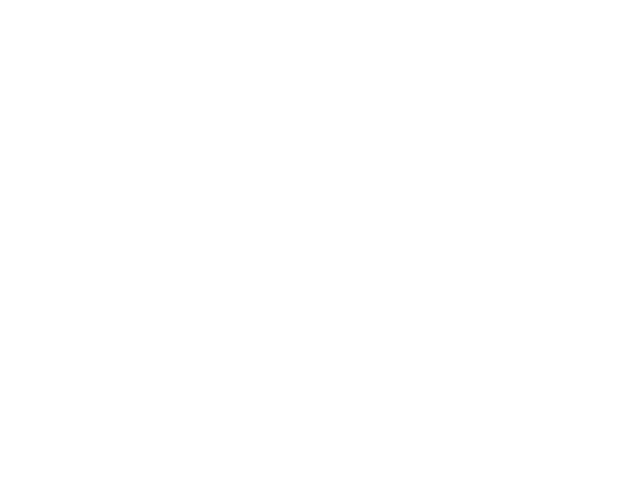

<IPython.core.display.Javascript object>


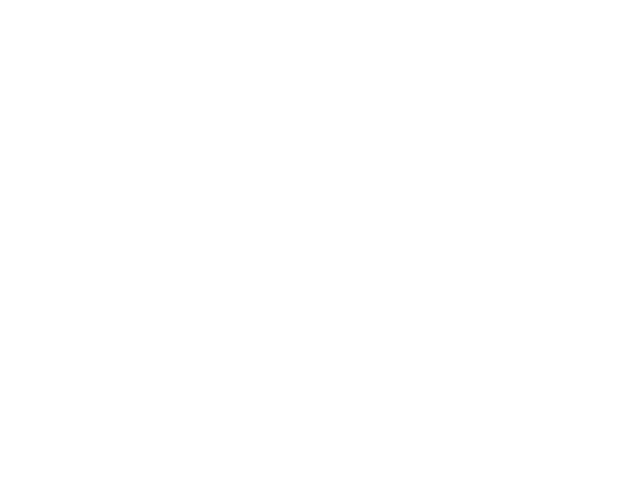

In [11]:
plt.figure()
plt.plot(accs)
plt.title('Accuracy in %')
plt.xlabel('Epoch')
plt.grid()

plt.figure()
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Epoch')
plt.grid()

To see the result we load random images from the test dataset and classify them with the trained RNN.

**Task**: 
1. Restart the notebook and play all cells up to the training step. Change the number of epochs to $1$ but do not start the training!
2. Run the following cell to see the performance of the model.
3. Train for $1$ epoch and go back to step 2. of this task

The performance of the RNN should increase with each epoch.

<IPython.core.display.Javascript object>


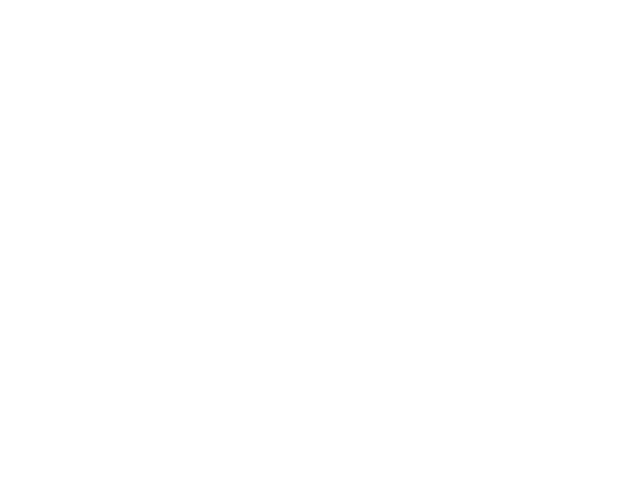

In [12]:
example_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1, shuffle=True)

fig2 = plt.figure()
ax2 = fig2.gca()

def function_for_animation(frame_index):
    ax2.clear()
    
    example_iter = iter(example_loader)
    example_image = next(example_iter)
    image = example_image[0][0, 0]

    image = ax2.imshow(image, animated=True, cmap='gray_r')
    
    with torch.no_grad():
        pred = model(example_image[0])
        digit = torch.argmax(pred).item()
    ax2.set_title('digit: '+str(digit))
    
    plt.draw()
    return image,

ani = matplotlib.animation.FuncAnimation(fig2, function_for_animation, interval=1500, frames=28, blit=True)